# Chapter 34

# Dealing with Messy Time Series 

## Introduction   

In the preceeding 2 chapters we have focused on the key properties of time series data and on creating basic models for time series forecasting. The models we explored decomposed time series into unobserved components, trend, random walk, seasonal and stochastic. This type of model can be effective in many cases, as you have seen in the preceeding chapter. But many real-world time series are show more complex behavior than the basic models allow.  

In this chapter we will explore two improtant advanced time series model extensions on the basic models:     
1. The mdoels we have used so far, only accomodate decomposition with one seasonal component. However in many cases, there is more than one seasonal period. For these cases, we need a decomposistion that will account for multi-period seasonal behavior. Examples of seasonal components which might be simultaniously present in a time series include:     
    - **Hourly variation** is common in many time series, such as modeling demand for business services or temperature series.   
    - **Day of the week variation** is often found in business and economic time series.     
    - **Annual variation** is common in both business and natual time series. Such seasonality is see in both monthly and quarterly data. Business and economic data often show such cycles, which in fact, is the origin of the term seasonal variation. Wildlife populations and other natural time series often have annual components as well.       
2. Up to now, we have only worked with univariate time series models. However, it is very common to have covariates that provide information which add information to the forecasting model. Such variables are often referred to as 'exogonous' since they are not a component of the endogounous time series to be forecast. The choice of exogonous vairables one can use to improve a forcasting model can be quite problem specific. Some examples include:    
    - **Holidays** can have a significant effect on business and economic time series. Holidays can fall on a specific date, such as New Year's Day, A releative calendar date, such as the 4th Thursday in November for the US Thanksgiving holiday. Other holidays can follow a lunar calendar, such as Ramdan or Easter. Further, holiday effects can proceed or lag the actual holiday date. For example, beer and snack purchases rise in the days leading up to the Super Bowl Sunday in the US.      
    - **Weather** can effect both business process, such as ice cream sales, as well as natural processes, such as growth of plants.    
    
In this chapter we will extend the basic time series models to incorprate these effects.     

In [1]:
#!pip install -U sktime

In [2]:
from math import sin, cos,pi
import pandas as pd
import numpy as np
import numpy.random as nr
from scipy.stats import zscore
import sklearn.linear_model as lm
import statsmodels.tsa.seasonal as sts
import scipy.stats as ss
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sktime.detection.stray import STRAY
from sktime.detection.bs import BinarySegmentation

from scipy import fft
import calendar
import itertools 
import pmdarima as pm
import statsmodels.graphics.tsaplots as splt
import matplotlib.pyplot as plt
import warnings 

%matplotlib inline

def plot_ts(ts, lab = '', xlab='Date', ax=None, alpha=1.0, linewidth=1.0):
    if ax == None: _,ax = plt.subplots(figsize=(9,4))
    ts.plot(ax=ax, alpha=alpha, linewidth=linewidth)
    ax.set_title('Time series plot of ' + lab)
    ax.set_ylabel('Value')
    ax.set_xlabel(xlab)
    
def dist_ts(ts, lab = '', bins = 40):
    _,ax = plt.subplots(1,2,figsize=(10,4))
    ## Plot the histogram with labels
    ts.hist(ax = ax[0], bins = bins, alpha = 0.5);
    ax[0].set_xlabel('Value');
    ax[0].set_ylabel('Frequency');
    ax[0].set_title('Histogram of ' + lab);
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax[1]);
    
def auto_partial_corr_plot(ts):
    _,ax = plt.subplots(2,1, figsize=(8,8))
    _=splt.plot_acf(ts, lags = 40, ax=ax[0]);
    _=splt.plot_pacf(ts, lags = 40, method='yw', ax=ax[1]);
    
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) 
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )        

def test_stationarity(series, regression_model='c', rounding=3):
    """Function to test the stationarity of time series using:
    1. Augmented Dicky Fuller test using AIC 
    2. KPSS test for constant
    
    Arguments:  
        Series: the time series to be evaluated.   
        regression_model: model to be used:   
            'c' - model with a constant   
            'ct' - model wiht a constant and trend  
        rounding: the number of digits to display in printed output.   
    """
    if regression_model not in ['c','ct']:    
        print('Error!: argument regression model must be one of {\'c\',\'ct\'}')
        return
    with warnings.catch_warnings(): 
        warnings.filterwarnings("ignore")
        kpss_test = kpss(series, regression=regression_model)
        ADF_test = adfuller(series, regression=regression_model, autolag="AIC")
    return [round(ADF_test[0],rounding), round(ADF_test[4]['5%'],rounding), round(ADF_test[1],rounding),
                                       round(kpss_test[0],rounding), round(kpss_test[1],rounding)]
def stationary_tests(series, names, regression_model='c', rounding=3):
    test_columns = ['ADF_statistic','ADF_conf_int','ADF_p_value','KPSS_statistic','KPSS_p_value']
    out = pd.DataFrame(index=names, columns=test_columns)    
    for ser, name in zip(series,names):  
        out.loc[name,:] = test_stationarity(ser, regression_model=regression_model, rounding=rounding)
    return out

def auto_partial_corr_plot(ts, lags=40):
    _,ax = plt.subplots(2,1, figsize=(8,8))
    _=splt.plot_acf(ts, lags=lags, ax=ax[0]);
    _=splt.plot_pacf(ts, lags=lags, method='yw', ax=ax[1]);
    

def dist_ts(ts, lab = '', bins = 40):
    _,ax = plt.subplots(1,2,figsize=(10,4))
    ## Plot the histogram with labels
    ts.hist(ax = ax[0], bins = bins, alpha = 0.5);
    ax[0].set_xlabel('Value');
    ax[0].set_ylabel('Frequency');
    ax[0].set_title('Histogram of ' + lab);
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax[1]);


## Example Data

We will not generate a univariate time series with two seasonal periods, weekly and annual. Such multiperiod seasonal behavior is found in many real-world time series.  

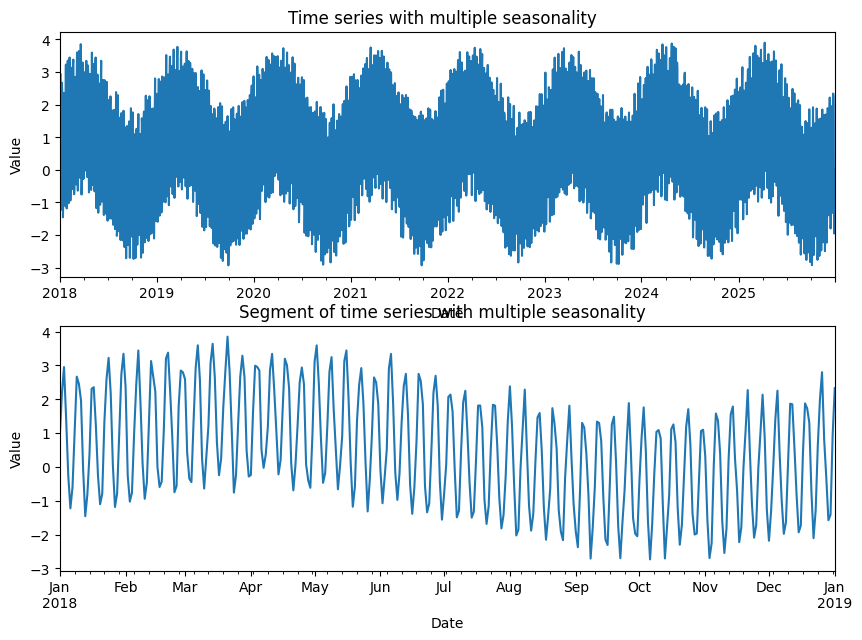

In [3]:
## Create a synthetic time series with multiple seasonality 
ts = pd.Series(np.random.rand(8 * 365), index=pd.date_range(start='2018-01-01', periods= 8 * 365, freq='D'))
ts += 2 * np.sin(np.arange(len(ts)) * 2 * np.pi / 7)   # Weekly seasonality
ts += np.sin(np.arange(len(ts)) * 2 * np.pi / 365.25)  # Annual seasonality

_,ax = plt.subplots(2, 1, figsize=(10,7))
ts.plot(ax=ax[0])
ax[0].set_title('Time series with multiple seasonality  ');
ax[0].set_ylabel('Value');
ax[0].set_xlabel('Date');
ts[:'2019-01-01'].plot(ax=ax[1])
ax[1].set_title('Segment of time series with multiple seasonality  ');
ax[1].set_ylabel('Value');
ax[1].set_xlabel('Date');

## Power Spectrum of Time Series

A useful way to understand the effect of a filter on the image is to examine the power spectrum of the time seris. This is done by decomposing the time series into its sinusodial components of different frequencies. This decomponsition is know as a [**Fourier transform**](https://en.wikipedia.org/wiki/Fourier_transform). We will not purse any detail in this discussion, going only far enough to gain a basic ability to interpret the results.   

To compute a Fourier transform on a discretely sampled data, such as digital image data, the [**discrete Fourier transform (DFT)**](https://en.wikipedia.org/wiki/Discrete_Fourier_transform). For a one dimensional sequential sample, $\mathbf{x} = [x_1, x_2, x_3, \ldots, x_n]$, we can decompose this sequence into a sequence of complex frequency components, $\mathbf{\Omega} = [\omega_0, \omega_1, \omega_2, \ldots, \omega_{N-1}]$. The basic DFT for one frequency component, $X_k$, is formulated as:        

$$\Omega_k = \sum_{n=0}^{N-1} x_n \cdot e^{-\frac{i2\pi}{N}kn}$$

How can we understand this complex looking relationship? First, recall that the $i$ symbol indicates a complex number. Next, it is useful to note that we can represent a complex exponential function into sin and cos function using [**Euler's formula**](https://en.wikipedia.org/wiki/Euler%27s_formula):

$$
e^{-i\ q} = cos(q) - i\ sin(q)\\   
$$

Applying Euler's formula to the DFT, we get the following relation:  

$$
\Omega_k = \sum_{n=0}^{N-1} x_n cos \Bigg(\frac{2 \pi}{N}kn \Bigg) - i\ x_n\ sin \Bigg( \frac{2 \pi}{N}kn \Bigg)
$$ 

From the above relationships one can see that the DFT is a linear superposition of the complex sinusiods with the sequence $\mathbf{x}$. Each component, $X_k$, represents the a coefficeint for a specific frequency and phase. Another way to understand the DFT is as a convolution between the sinusods of different frequencies and phases and the sequence, $\mathbf{x}$. Phase is represented by the complex value.  

For our purposes here, we are not interested in the complex representation. Rather, we are interested in the **power spectrum**. The power spectrum is the square of the magnitude of the spectral components. The power spectrum is symmetric about zero. Each frequncy component is represented on both the positive side and the negative side.   

The code in the cell below computes and plots the Fourier power spectrum of the example time series. 

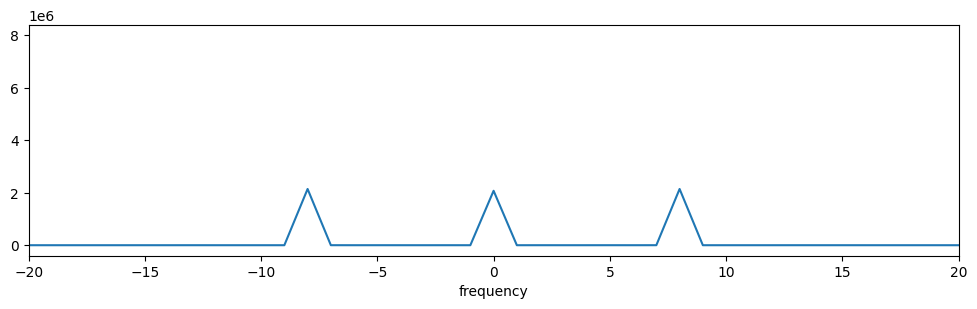

In [4]:
def compute_power_spectrum(series): 
    ## Compute the Fourier transform and power spectrum
    edge_fft = np.fft.fft(series)
    return np.square(np.abs(fft.fftshift(edge_fft)))

def series_spectrum_plot(series, xlim=(-20, 20), years=8): 
     ## Compute the axis lables for the power specture  
    frequencies = int(len(spectrum)/2)
    frequencies = range(-frequencies, frequencies, 1)
    frequencies = [f/(years/8) for f in frequencies] # Scale the frequencies 

    ## Plot the time series and the power spectrum     
    _,ax = plt.subplots( figsize=(12,3))
    ax.plot(frequencies, spectrum);
    ax.set_xlabel('frequency')
    ax.set_xlim(xlim[0], xlim[1])

## Compute the Fourier transform and power spectrum
spectrum = compute_power_spectrum(ts)

## Plot the time series and the power spectrum     
series_spectrum_plot(spectrum)

## Apply MSTL

The **multiple seasonal trend decomposition using LOESS (MSTL)** algorithm allows us into the following components.     
1. A nonlinear trend component computed using LOESS local regression.
2. Multiple seasonal components at the periods specified.
3. The residual of the time series with the trend and seasonal components removed.  


The code in the cell below uses the [MSTL implementation in statsmodels.tsa](decomposition using LOESS). 

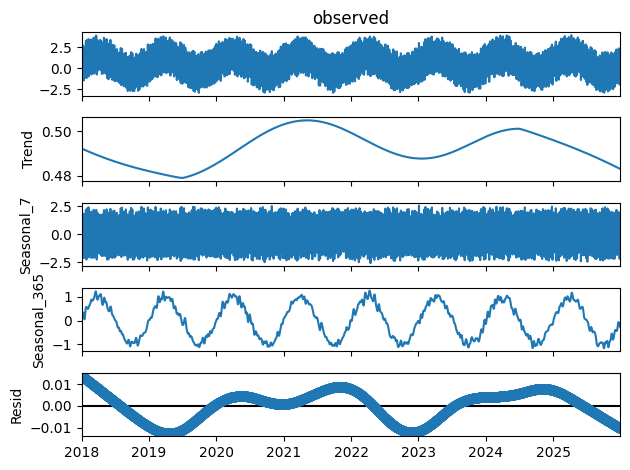

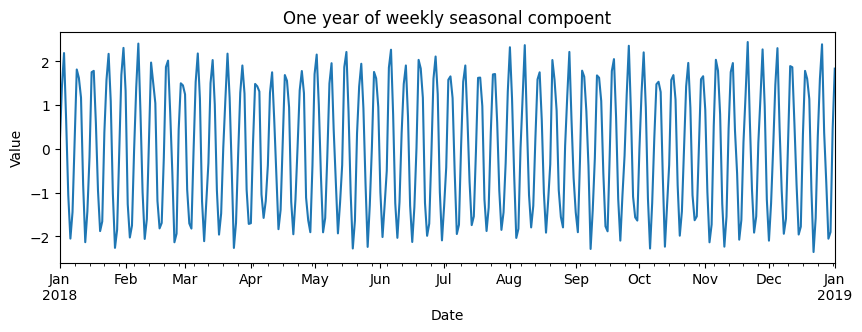

In [5]:
window = [3, 3]
periods = [7, 365]
multi_period_decomposion = sts.MSTL(ts, 
                                    periods = periods,
                                    windows = window,
                                   ).fit()


multi_period_decomposion.plot()
plt.tight_layout()
plt.show()

_,ax = plt.subplots(figsize=(10,3))
multi_period_decomposion.seasonal.loc[:'2019-01-01','seasonal_7'].plot(ax=ax)
ax.set_title('One year of weekly seasonal compoent');
ax.set_ylabel('Value');
ax.set_xlabel('Date');

## SARIMAX Model For Multiseasonality

The basic SARIMAX model allows for a single seasonal differencing term for a single seasonal period. But we can easily extend SAEIMAX to multiple seasonality time series, using exogonous variables.    

In this case the annual periodic behavior is simple sinusoid. Therefore we can use a single pair of [Fourier harmonics](https://en.wikipedia.org/wiki/Harmonic_analysis) to model this behavior. For more complex seasonal patterns we will need additional harmonics.   

The code in the cell below creates and displays an exogonus pair of Fourier harmonics.  

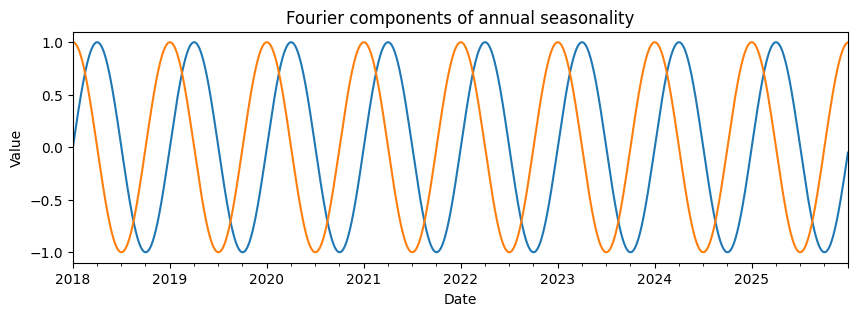

In [6]:
## Create exogonous variable for annual seasonality 
annual_fourier_terms = pd.DataFrame({
    'sin_annual_1': np.sin(np.arange(len(ts)) * 2 * np.pi / 365.25),
    'cos_annual_1': np.cos(np.arange(len(ts)) * 2 * np.pi / 365.25)
})
annual_fourier_terms.index = ts.index

_,ax = plt.subplots(figsize=(10,3))
for col in ['sin_annual_1', 'cos_annual_1']:
 annual_fourier_terms[col].plot(ax=ax)
ax.set_title('Fourier components of annual seasonality');
ax.set_ylabel('Value');
ax.set_xlabel('Date');

The code in the cell below instantiates and fits a SARIMAX model accounting for the twp seasonal periods:    
1. The weekly period (7 days) is modeled by first-order differencing.
2. The annual component is modeled using the exogounous Fourier harmonic variables.

The last year of the time series is withheld as a test.  

In [7]:
SARIMAX_model = SARIMAX(ts[:'2024-12-31'],
                exog=annual_fourier_terms[:'2024-12-31'], # for annual seasonality 
                order=(0, 0, 0),
                seasonal_order=(0, 1, 0, 7), # for weekly seasonality 
                enforce_stationarity=False,
                enforce_invertibility=False).fit()

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                 2557
Model:             SARIMAX(0, 1, 0, 7)   Log Likelihood               -1312.528
Date:                 Thu, 04 Dec 2025   AIC                           2631.056
Time:                         12:04:53   BIC                           2648.586
Sample:                     01-01-2018   HQIC                          2637.414
                          - 12-31-2024                                         
Covariance Type:                   opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sin_annual_1     0.9878      0.093     10.591      0.000       0.805       1.171
cos_annual_1    -0.0065      0.095     -0.068      0.946      -0.194       0.181
sigma2           0.1640      0.005     30.286      0.000       0.153       0.175
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                33.50
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.04
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The code in the cell below computes the SARIMAX model perdiciton of the last year of the time series. The actual time series, the prediction and the prediction confidence intervals are all displayed.   

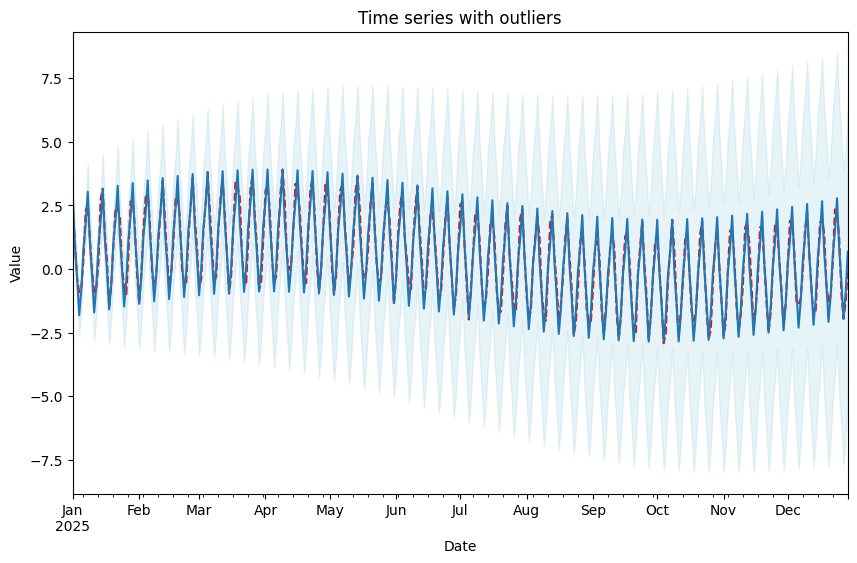

In [8]:
test_length = len(ts['2025-01-01':])
forecast = SARIMAX_model.get_forecast(steps=test_length, exog=annual_fourier_terms['2025-01-01':])

CIs = forecast.conf_int()

_,ax = plt.subplots(figsize=(10,6))
ts['2025-01-01':].plot(ax=ax, c='red', linestyle='--')
forecast.predicted_mean.plot(ax=ax)
ax.fill_between(CIs.index,
             CIs.iloc[:,0],
             CIs.iloc[:,1], 
             color="lightblue", 
             alpha=0.3)
ax.set_title('Time series with outliers');
ax.set_ylabel('Value');
ax.set_xlabel('Date');

## Anomaly Detection    

Messy time series often contain anomalies. There is a vast literature and many implementations of time series anomaly detection algorithms. Without going into any depth we will look at methods to detect two common time series anomalies.    
1. **Outliers**, or unusual values.     
2. **Change points** where a time series experiences a shift in statistical properties such as mean, trend, variance, etc.  

### Outlier Detection

As a first example we will add some outliers to the multiseasonal time series.  

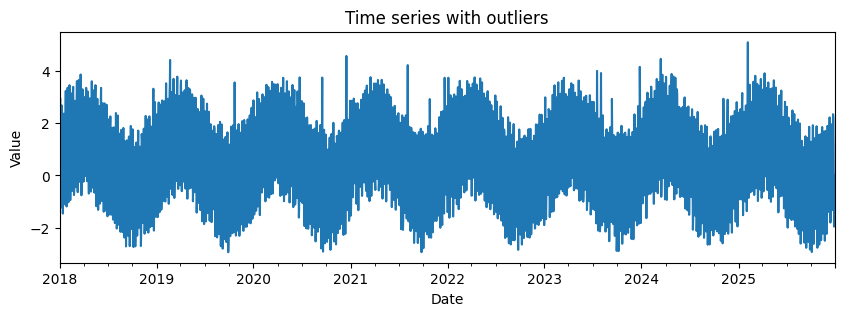

In [9]:
outliers_index = np.sort(np.random.choice(range(len(ts)), size=50, replace=False))
outliers = np.array([0.0]*len(ts))
outliers[outliers_index] = 2.0
ts_outliers = ts + outliers

_,ax = plt.subplots(figsize=(10,3))
ts_outliers.plot(ax=ax)
ax.set_title('Time series with outliers');
ax.set_ylabel('Value');
ax.set_xlabel('Date');

We will not instantiate and fit a [STRAY model from the sktime package](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.detection.stray.STRAY.html). The hyperparameters have been adjusted for the time series. The time series is displayed with the detected outliers shown in red markers.   

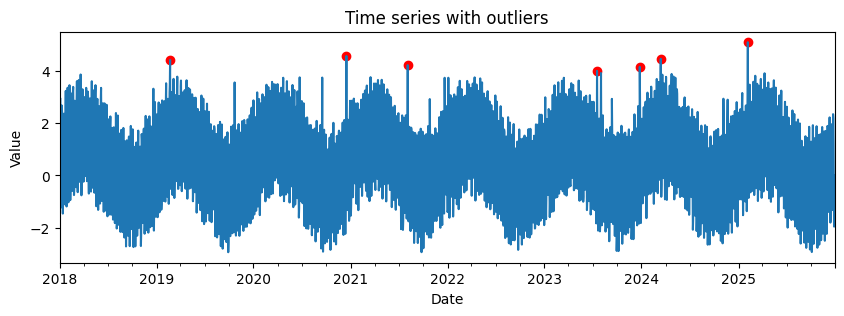

In [10]:
X = ts_outliers.to_numpy()
model = STRAY(alpha = 0.1, k=3)
y = model.fit_transform(ts_outliers)
detected = ts_outliers[y]

_,ax = plt.subplots(figsize=(10,3))
ts_outliers.plot(ax=ax)
ax.scatter(detected.index, detected, c='red')
ax.set_title('Time series with outliers');
ax.set_ylabel('Value');
ax.set_xlabel('Date');

### Change Point Detection 

We will now try a simple example of change point detection in a univariate time series.    

The code in the cell below adds a single change point to the multiperiod time series and displays the result.    

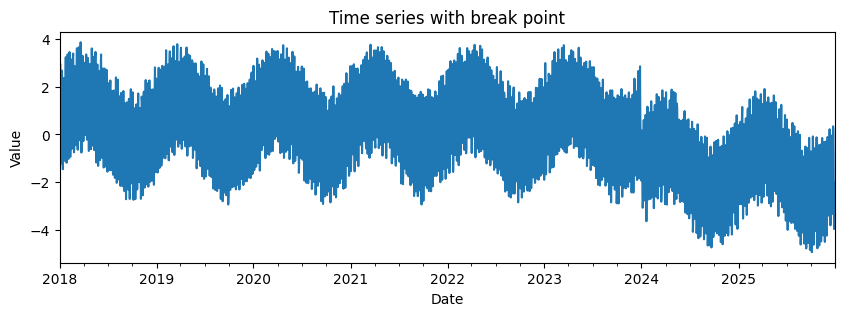

In [11]:
ts_break = ts.copy()
ts_break['2024-01-01':] = ts['2024-01-01':] - 2.0

_,ax = plt.subplots(figsize=(10,3))
ts_break.plot(ax=ax)
ax.set_title('Time series with break point');
ax.set_ylabel('Value');
ax.set_xlabel('Date');

The code in the cell below uses the [BinarySegmentation algorithm from the sktime package](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.detection.bs.BinarySegmentation.html) to locate the change point in the time series. The result is displayed as a vertical red line. 

   ilocs
0   2188


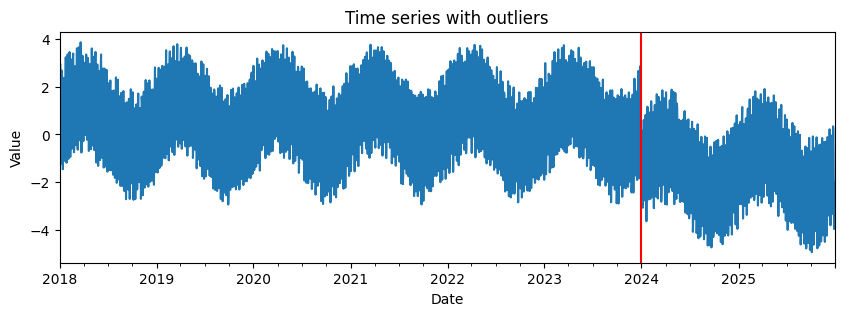

In [12]:
model = BinarySegmentation(threshold=20)
predicted_change_points = model.fit_predict(ts_break)
print(predicted_change_points)

_,ax = plt.subplots(figsize=(10,3))
ts_break.plot(ax=ax)
ax.axvline(ts_break.index[predicted_change_points.iloc[0].iloc[0]], 
           ymin = np.min(ts_break),
           ymax = np.max(ts_break),
           c = 'red')
#ax.axvline(x=2920, color='r')
ax.set_title('Time series with outliers');
ax.set_ylabel('Value');
ax.set_xlabel('Date');

### Fitting a SARIMAX Model with a Change Point     

We can easily include the change point into a SARIMAX model. The code in the cell below creates another exogonous variable that has a binary, $\{0,1\}$ value that changes from $0$ to $1$ past the change point. The extended exogonous set of variables are then used to fit a SARIMAX model using the code below. Notice that the 'predict' method is used here, rather than 'get_forecast' since we are interested in the in-sample predicitons.   

In [13]:
annual_fourier_terms['outliers'] = np.array([0.0]*len(X))
annual_fourier_terms.loc[ts_break.index[predicted_change_points.iloc[0].iloc[0]]:, 'outliers'] = 1.0

SARIMAX_model = SARIMAX(ts_break,
                exog=annual_fourier_terms, # for annual seasonality and change point
                order=(0, 0, 0),
                seasonal_order=(0, 1, 0, 7), # for weekly seasonality 
                enforce_stationarity=False,
                enforce_invertibility=False).fit()

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                 2920
Model:             SARIMAX(0, 1, 0, 7)   Log Likelihood               -1556.284
Date:                 Thu, 04 Dec 2025   AIC                           3120.568
Time:                         12:04:56   BIC                           3144.475
Sample:                     01-01-2018   HQIC                          3129.181
                          - 12-29-2025                                         
Covariance Type:                   opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sin_annual_1     0.9600      0.090     10.674      0.000       0.784       1.136
cos_annual_1    -0.0047      0.093     -0.051      0.960      -0.187       0.177
outliers        -1.3433      0.051    -26.113      0.000      -1.444      -1.243
sigma2           0.1705      0.004     39.690      0.000       0.162       0.179
===================================================================================
Ljung-Box (L1) (Q):                   3.29   Jarque-Bera (JB):                13.46
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The code in the cell below plots the time series and the SARIMAX prediction for the time series for the 6 months before and 6 month after the change point. 

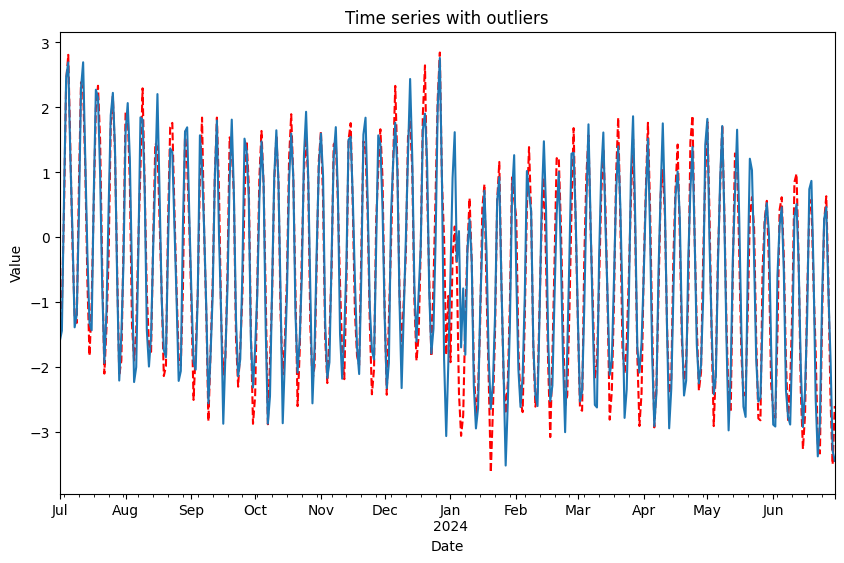

In [14]:
test_length = len(ts['2025-01-01':])
predicted = SARIMAX_model.predict(exog=annual_fourier_terms['2025-01-01':])

_,ax = plt.subplots(figsize=(10,6))
ts_break['2023-07-01':'2024-06-30'].plot(ax=ax, c='red', linestyle='--')
predicted['2023-07-01':'2024-06-30'].plot(ax=ax)
ax.set_title('Time series with outliers');
ax.set_ylabel('Value');
ax.set_xlabel('Date');

### Copyright 2023, 2025 Stephen F Elston. All rights reserved.  